##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Illustrating a book using Imagen 3

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this guide, you are going to use multiple Gemini features (long context, multimodality, structured output, file API, chat mode...) in conjunction with the Imagen 3 model to illustrate a book.

Each concept will be explained along the way, but if you need a simpler introduction to Imagen 3, check the [getting started](../quickstarts/Get_started_imagen.ipynb) notebook, or the [Imagen documentation](https://ai.google.dev/gemini-api/docs/imagen).

Note: for the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>Image generation is a paid-only feature and won't work if you are on the free tier. Check the <a href="https://ai.google.dev/pricing#imagen3"><font color='#217bfe'>pricing</font></a> page for more details.</font></h3>
    </td>
  </tr>
</table>

## 0/ Setup

This section install the SDK, set it up using your [API key](../quickstarts/Authentication.ipynb), imports the relevant libs, downloads the sample videos and upload them to Gemini.

Just collapse (click on the little arrow on the left of the title) and run this section if you want to jump straight to the examples (just don't forget to run it otherwise nothing will work).

### Install SDK


In [ ]:
%pip install -U -q "google-genai"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.8.0 which is incompatible.


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://link_to_vertex_AI)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Imports

Some imports to display markdown text and images in Colab.

In [ ]:
import json
from PIL import Image
from IPython.display import display, Markdown

### Select models

In [ ]:
imagen_model_name = "imagen-3.0-generate-002"  # @param ["imagen-3.0-generate-002"] {"allow-input":true, isTemplate: true}
gemini_model_name = "gemini-2.5-flash"  # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash-lite-preview-09-2025", "gemini-2.5-flash", "gemini-2.5-flash-preview-09-2025", "gemini-2.5-pro"] {"allow-input":true, isTemplate: true}

For the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

In [ ]:
max_character_images = 3 # @param {type:"integer",isTemplate: true, min:1}
max_chapter_images = 3 # @param {type:"integer",isTemplate: true, min:1}

# Illustrate a book: The Wind in the Willows

## 1/ Get a book and upload using the File API

Start by downloading a book from the open-source [Project Gutenberg](www.gutenberg.org) library. For example, it can be [The Wind in the Willows](https://en.wikipedia.org/wiki/The_Wind_in_the_Willows) from Kenneth Grahame.

`client.files.upload` is used to upload the file so that Gemini can easily access it.

In [ ]:
import requests

url = "https://www.gutenberg.org/cache/epub/289/pg289.txt"  # @param {type:"string"}

response = requests.get(url)
with open("book.txt", "wb") as file:
    file.write(response.content)

book = client.files.upload(file="book.txt")


## 2/ Start the chat

You are going to use [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here so that Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time. More details on chat mode in the [Get Started](https://colab.sandbox.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb#scrollTo=b6sB7W-jdGxJ) notebook.

You should also define the format of the output you want using [structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json). You will mainly use Gemini to generate prompts so let's define a Pydantic model with two fields, a name and a prompt:

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


`client.chats.create` starts the chat and defines its main parameters (model and the output you want).

In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(
    [
        "Here's a book, to illustrate using Imagen. Don't say anything for now, instructions will follow.",
        book
    ]
);

The first message sent to the model is just to give it a bit of context ("*to illustrate using Imagen*"), and more importantly give it the book.

It could have been done during the next step, especially since you're not interested in what the model has to say this time, but splitting the two steps makes it clearer.

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style=="":
  response = chat.send_message("""
    Can you define a art style that would fit the story?
    Just give us the prompt for the art syle that will added to the furture prompts.
    """)
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f"""
    The art style will be:"{style}".
    Keep that in mind when generating future prompts.
    Keep quiet for now, instructions will follow.
  """)

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

Illustration, watercolor painting, golden age illustration style, detailed, vibrant colors, pastoral scenes, anthropomorphic animals


Let's also define some more instructions which will act as "system instructions" or a negative prompt to tell the model what you do not want to see (text on the images).

In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

Ask Gemini to describe each of the main characters (excluding children as Imagen can't generate images of them) and check that the output follows the format requested.


In [ ]:
response = chat.send_message("""
  Can you describe the main characters (only the adults) and
  prepare a prompt describing them with as much details as possible (use the descriptions from the book)
  so Imagen can generate images of them? Each prompt should be at least 50 words.
""")

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Badger Prompt",
        "prompt": "Illustration of Badger, wearing a long dressing-gown and down-at-heel slippers, carrying a flat candlestick.  He has a long snout, sleepy blinking eyes and a grave expression. The badger is kind but stern, with visible wrinkles. He has stout oaken, comfortable-looking doors in his underground home and is holding a sturdy wooden walking stick. He is old, and very tired from walking far, but has very sharp claws. His dressing gown should be a dark, earthy tone and have a simple but practical design with a large red cotton handkerchief."
    },
    {
        "name": "Water Rat Prompt",
        "prompt": "Illustration of Water Rat,  well-groomed and neat. Wearing a black velvet smoking-suit, clean and pressed, but slightly worn from extensive river activity, and a boater hat. His neat ears and thick silky hair are visible.  He is jovial but serious, holding a pair of sculls.  His fur is sleek and well-maintained, reflecting his co

Now that you have the prompts, you just need to loop on all the characters and have Imagen generate an image for them. This is done using `client.models.generate_images`.

For an extensive explanation on the Imagen model and the `generate_images` options, check the [getting started with Imagen](../quickstarts/get_started_imagen.ipynb) notebook. But here's a quick overview of what being used here:
* `prompt` is the prompt passed down to Imagen. You're not just sending what Gemini has generate to describe the chacaters but also our style and our system instructions.
* you only need one image, so `number_of_images` is set to 1
* `safety_filter_level` is set to the higher level because the images needs to be family friendly
* `person_generation` is disable since none of the characters are people

In [ ]:
for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

# Be careful; long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here's what it should look like when you run it:

-----------
**Badger Prompt**  
Illustration of Badger, wearing a long dressing-gown and down-at-heel slippers, carrying a flat candlestick. He has a long snout, sleepy blinking eyes and a grave expression. The badger is kind but stern, with visible wrinkles. He has stout oaken, comfortable-looking doors in his underground home and is holding a sturdy wooden walking stick. He is old, and very tired from walking far, but has very sharp claws. His dressing gown should be a dark, earthy tone and have a simple but practical design with a large red cotton handkerchief.

![Generated image of the 1st character](https://storage.googleapis.com/generativeai-downloads/images/character1.png)

**Water Rat Prompt**  
Illustration of Water Rat, well-groomed and neat. Wearing a black velvet smoking-suit, clean and pressed, but slightly worn from extensive river activity, and a boater hat. His neat ears and thick silky hair are visible. He is jovial but serious, holding a pair of sculls. His fur is sleek and well-maintained, reflecting his connection to the river, and has river shop and is always wanting you to do something as if a fellow had no business of his own to attend to. The background is lush riverbank.

![Generated image of the 2nd character](https://storage.googleapis.com/generativeai-downloads/images/character2.png)

**Toad Prompt**  
Illustration of Toad, Boastful and conceited. He is short and stout, and often wears flamboyant clothing and is about to order a motor-car from a townsperson who is showing him a poster. This is a new craze, and he always takes him that way. He has a placid satisfied expression and at intervals he faintly murmurs “Poop-poop!”. The scene will take place near a building showing motorcar advertisements.

![Generated image of the 3rd character](https://storage.googleapis.com/generativeai-downloads/images/character3.png)


## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [ ]:
response = chat.send_message("Now, for each chapters of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Be very descriptive and remember to reuse the character prompts if they appear in the images. Each character should at least be described with 30 words.")

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter I Prompt",
        "prompt": "Illustration of Mole, a small, black-furred animal with splashes of whitewash all over him, working busily with brooms and brushes in his dark, lowly little house, preparing for spring cleaning. Rat, well-groomed and neat in his black velvet smoking-suit, is sculling in his blue and white boat, casually dressed and leisurely enjoying the river. The full-fed river itself, a sleek, sinuous, full-bodied animal, reflects the warm sunlight and happy birds, and the riverbank is lush and green. Mole looks up and see's Rat for the first time, a grave brown round face, with the same twinkle in its eye that had first attracted his notice."
    },
    {
        "name": "Chapter II Prompt",
        "prompt": "Illustration of Rat, cheerful in his boater hat, dismissing poetry from his mind as he jumps to his feet. Mole is shorter with his head a little bit down wearing a black velvet smoking-suit. They are on their way to call on Mr. To

In [ ]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

# Be careful, long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here's what it should look like when you run it:

-----------
**Chapter I Prompt**  
Illustration of Mole, a small, black-furred animal with splashes of whitewash all over him, working busily with brooms and brushes in his dark, lowly little house, preparing for spring cleaning. Rat, well-groomed and neat in his black velvet smoking-suit, is sculling in his blue and white boat, casually dressed and leisurely enjoying the river. The full-fed river itself, a sleek, sinuous, full-bodied animal, reflects the warm sunlight and happy birds, and the riverbank is lush and green. Mole looks up and see's Rat for the first time, a grave brown round face, with the same twinkle in its eye that had first attracted his notice.

![Generated image of the 1st chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter1.png)


**Chapter II Prompt**  
Illustration of Rat, cheerful in his boater hat, dismissing poetry from his mind as he jumps to his feet. Mole is shorter with his head a little bit down wearing a black velvet smoking-suit. They are on their way to call on Mr. Toad, whose house is dignified old house of mellowed red brick, with well-kept lawns. Toad is resting in a wicker garden-chair, with a pre-occupied expression and a large map. Hooray!” he cried, jumping up on seeing them. This is a sunny summer morning.

![Generated image of the 2nd chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter2.png)


**Chapter III Prompt
Illustration of Mole, small and dark furred, alone and increasingly frightened in the Wild Wood in Winter. Wicked faces pop out of holes around him, while wind whistles shrilly through the leafless trees and pattering footsteps come ever closer. He is running clumsily through the snow, trying to find a safe place to hide. Warm and comfortable Rat is inside dozing and alternating dozing and trying over rhymes that wouldn’t fit.

![Generated image of the 3rd chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter3.png)


# With an Audiobook: The Adventures of Chatterer the Red Squirrel

This time, you are going to use an audiobook as the source, and in this case *The Adventures of Chatterer the Red Squirrel* audiobook from the open-source library [Librivox](https://librivox.org/the-adventures-of-chatterer-the-red-squirel-by-thornton-w-burgess/).

## 1/ Get the audiobook and merge its chapters
You could upload all the chapters one by one, but it's easier to merge all the chapters together befor uploading the audiobook and only deal with one file.

For the sake of the length of the demonstration, you will only merge the first 5 chapters, but feel free to update the code and try on the full book.

In [ ]:
%pip install pydub
import os
import zipfile
from pydub import AudioSegment

# Download the zip file
!wget https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip

# Unzip the file
with zipfile.ZipFile("chatterertheredsquirrel_1307_librivox_64kb_mp3.zip", 'r') as zip_ref:
    zip_ref.extractall("audiobook")

# Get a list of all MP3 files in the extracted folder
mp3_files = [f for f in os.listdir("audiobook") if f.endswith('.mp3')]

mp3_files.sort()

if len(mp3_files) > 1:
    combined_audio = AudioSegment.empty()
    for i in range(min(5, len(mp3_files))):  # Limit to 5 or fewer chapters
        mp3_file = mp3_files[i]  # Get the filename using the index
        combined_audio += AudioSegment.from_mp3(os.path.join("audiobook", mp3_file))
    combined_audio.export("audiobook.mp3", format="mp3")
    print("MP3 files merged into audiobook.mp3")
else:
    print("Only one MP3 file found, no merging needed.")

--2025-03-08 17:01:56--  https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving www.archive.org (www.archive.org)... 207.241.224.2
Connecting to www.archive.org (www.archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-03-08 17:01:56--  https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600105.us.archive.org/12/items/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-03-08 17:01:57--  https://ia600

Now upload it using the File API:

In [ ]:
audiobook = client.files.upload(file="audiobook.mp3")

## 2/ Start the chat

Oonce again, using [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here let Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time.

[Structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) is used to force Gemini to output nice lists of prompts.

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(["Here's an audiobook, to illustrate using Imagen. Don't say anything for now, instructions will follow.",audiobook]);

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly. That's what is illustrated here with a futuristic style.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "futuristic, science fiction, utopia, saturated, neon lights" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style == "":
  response = chat.send_message("Can you define a art style that would fit the story? Just give us the prompt for the art syle that will added to the furture prompts.")
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f'The art style will be:"{style}". Keep that in mind when generating future prompts. Keep quiet for now, instructions will follow.')

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

futuristic, science fiction, utopia, saturated, neon lights


In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

In [ ]:
response = chat.send_message(["Can you describe the main characters and prepare a prompt describing them with as much details as possible (use the descriptions from the book) so Imagen can generate images of them?"])

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Chatterer the Red Squirrel Description",
        "prompt": "Create a futuristic, science fiction image of Chatterer the Red Squirrel: a small, agile squirrel with bright red, almost neon, fur. His eyes are beady and full of mischief, glowing with a faint light. He has a long, bushy tail, augmented with cybernetic enhancements, which he uses for balance and expression. He is always alert and energetic, constantly chattering and scampering about on technologically advanced trees, fitted with utopia components."
    },
    {
        "name": "Shadow the Weasel Description",
        "prompt": "Create a futuristic, science fiction image of Shadow the Weasel: a sleek and sinister weasel with a long, slender body and short legs, enhanced with subtle cybernetics for increased speed. His fur is a dark, shadowy color, almost absorbing light, and his eyes are beady and cunning, with a menacing red glow. He moves with a silent grace, often accompanied by faint neon trails, 

In [ ]:
for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

# Be careful, long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here's what it should look like when you run it:

-----------

**Chatterer the Red Squirrel Description**  
Create a futuristic, science fiction image of Chatterer the Red Squirrel: a small, agile squirrel with bright red, almost neon, fur. His eyes are beady and full of mischief, glowing with a faint light. He has a long, bushy tail, augmented with cybernetic enhancements, which he uses for balance and expression. He is always alert and energetic, constantly chattering and scampering about on technologically advanced trees, fitted with utopia components.

![Generated image of the 1st character](https://storage.googleapis.com/generativeai-downloads/images/character1_audio.png)


**Shadow the Weasel Description**  
Create a futuristic, science fiction image of Shadow the Weasel: a sleek and sinister weasel with a long, slender body and short legs, enhanced with subtle cybernetics for increased speed. His fur is a dark, shadowy color, almost absorbing light, and his eyes are beady and cunning, with a menacing red glow. He moves with a silent grace, often accompanied by faint neon trails, always lurking in the shadows of a technologically advanced environment, and waiting for his opportunity to strike.

![Generated image of the 2nd character](https://storage.googleapis.com/generativeai-downloads/images/character2_audio.png)


**Peter Rabbit Description**  
Create a futuristic, science fiction image of Peter Rabbit: a small and cautious rabbit with soft, brown fur, augmented with sensory enhancements, and long, floppy ears tipped with neon lights. His eyes are wide and innocent, but possess an augmented, digital overlay displaying threat assessment data. He always seems to be on the lookout for danger, relying on enhanced senses and agility to escape from trouble in a utopia inspired landscape.

![Generated image of the 3rd character](https://storage.googleapis.com/generativeai-downloads/images/character3_audio.png)


## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [ ]:
response = chat.send_message(["Now, for each chapter of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Remember to reuse the character prompts if they appear in the image"])

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter 1 Illustration Prompt",
        "prompt": "Create a futuristic, science fiction image of Chatterer the Red Squirrel running for his life through a forest filled with neon-lit, bioluminescent plants and towering, chrome trees. The forest floor is a mosaic of holographic projections, creating a surreal, dreamlike atmosphere. Utopia, saturated art style. Shadow the Weasel is in hot pursuit, his cybernetic eyes glowing with predatory hunger, leaving a faint neon trail that distorts the air. Chatterer, small and terrified, augmented with a speed booster that leaves a shimmering afterimage, leaps desperately from tree to tree, his bright red, neon-infused fur a blur against the vibrant background. Imagine the scene filled with a pounding synthwave soundtrack, with a sense of urgency and danger permeating the scene, emphasizing Chatterer's vulnerability and Shadow's relentless pursuit."
    },
    {
        "name": "Chapter 2 Illustration Prompt",
        "pro

### Chapter 1 Illustration Prompt

Create a futuristic, science fiction image of Chatterer the Red Squirrel running for his life through a forest filled with neon-lit, bioluminescent plants and towering, chrome trees. The forest floor is a mosaic of holographic projections, creating a surreal, dreamlike atmosphere. Utopia, saturated art style. Shadow the Weasel is in hot pursuit, his cybernetic eyes glowing with predatory hunger, leaving a faint neon trail that distorts the air. Chatterer, small and terrified, augmented with a speed booster that leaves a shimmering afterimage, leaps desperately from tree to tree, his bright red, neon-infused fur a blur against the vibrant background. Imagine the scene filled with a pounding synthwave soundtrack, with a sense of urgency and danger permeating the scene, emphasizing Chatterer's vulnerability and Shadow's relentless pursuit.

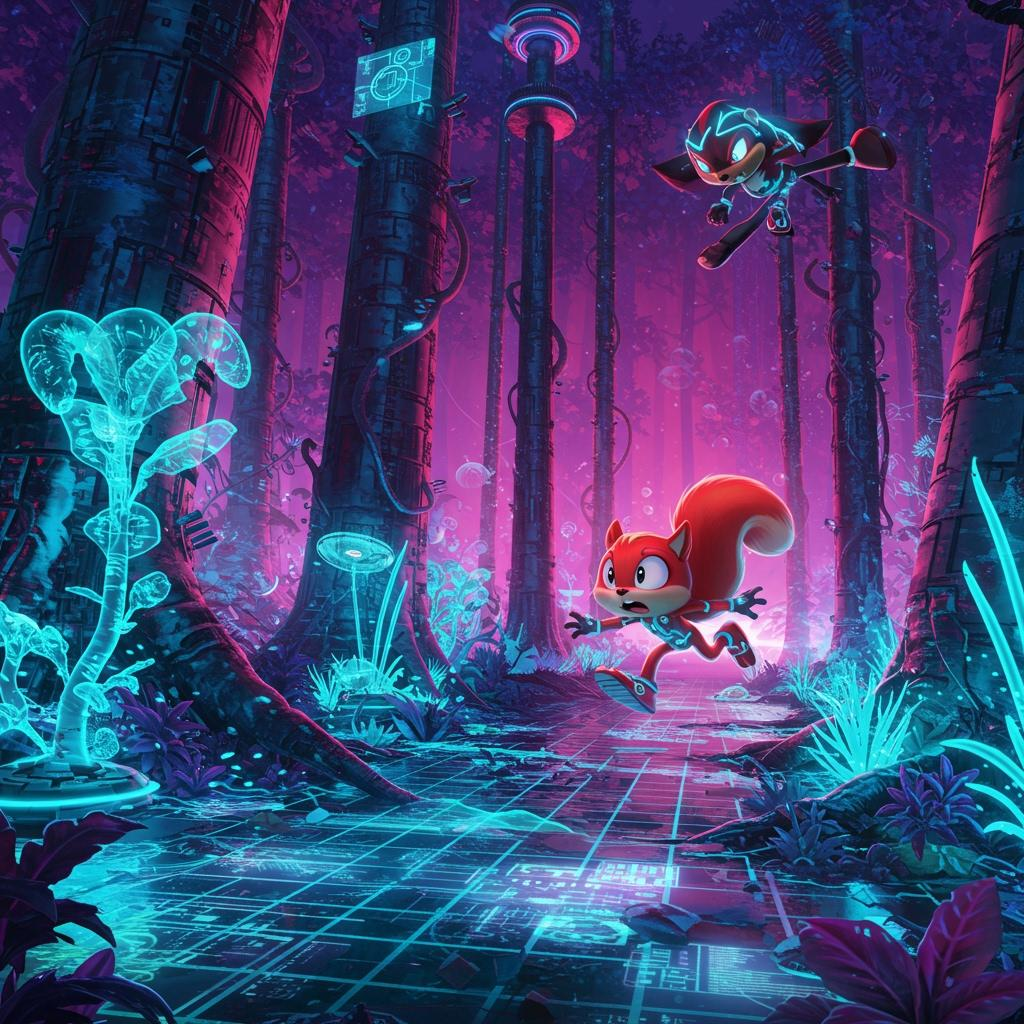

### Chapter 2 Illustration Prompt

Create a futuristic, science fiction image of Chatterer the Red Squirrel scrambling up a towering, genetically-modified chestnut tree that spirals upwards, supported by visible energy conduits, toward Red Tail the Hawk, who is dozing on a high-tech perch made of polished chrome, head tucked between his cybernetically enhanced shoulders. Utopia, saturated art style. Chatterer's augmented eyes are wide with a daring plan, calculating angles and trajectories, as Shadow the Weasel follows close behind, his movements leaving subtle distortions in the air and glitching holographic leaves. The scene should be a mix of tension and vibrant color, capturing the risk and ingenuity of Chatterer's actions, with neon accents illuminating the genetically-altered foliage and emphasizing the futuristic setting. Glimpses of advanced technology can be seen embedded within the tree's structure.

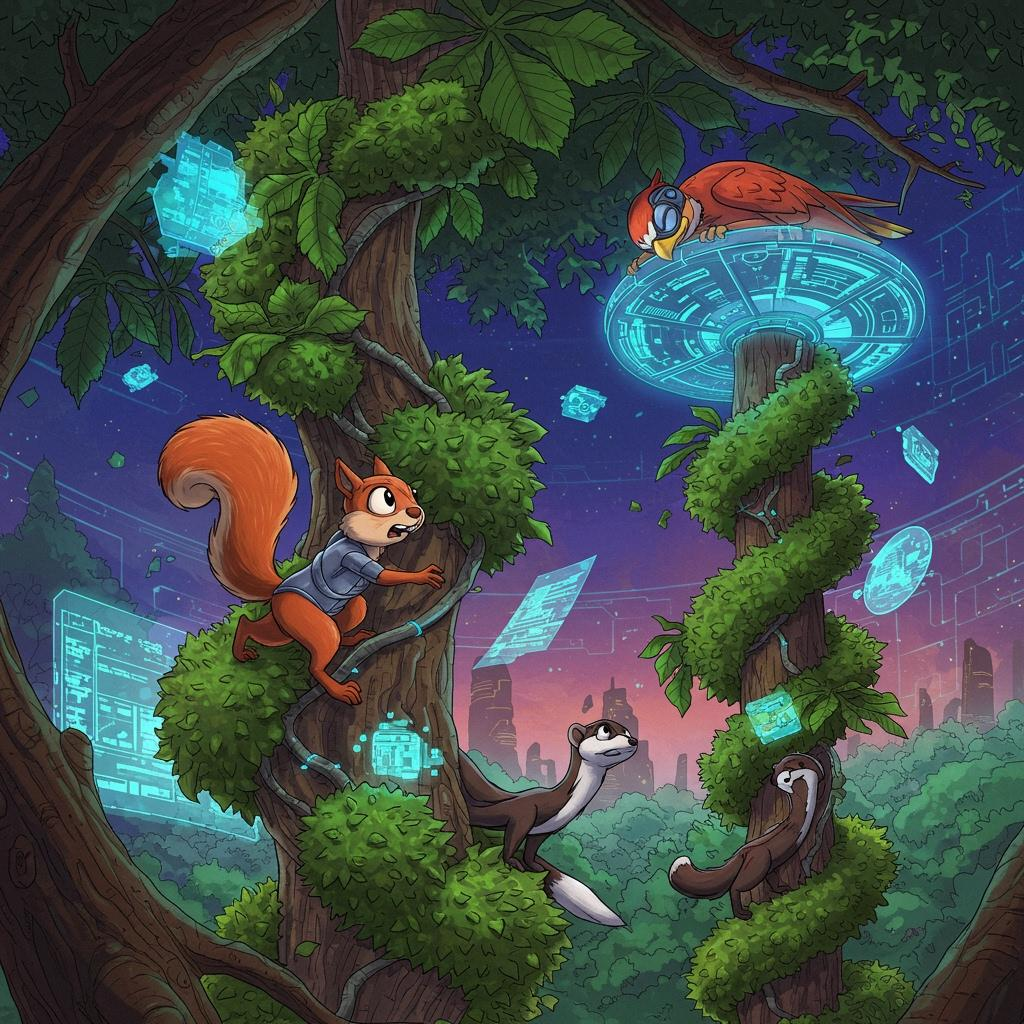

### Chapter 3 Illustration Prompt

Create a futuristic, science fiction image of Chatterer the Red Squirrel urgently telling Sammy Jay about Shadow the Weasel, their figures illuminated by glowing data streams. Utopia, saturated art style. Sammy Jay listens with wide, attentive eyes, augmented with holographic displays that project potential threats, perched on a branch of a tree constructed from shimmering, nanotech materials that seem to shift and change color. The lighting is vibrant, emphasizing the important news being shared, with a technologically advanced forest in the background hinting at the scale of Chatterer's warning. Holographic butterflies, acting as data couriers, flutter around Sammy as he processes the news, their wings leaving trails of light.

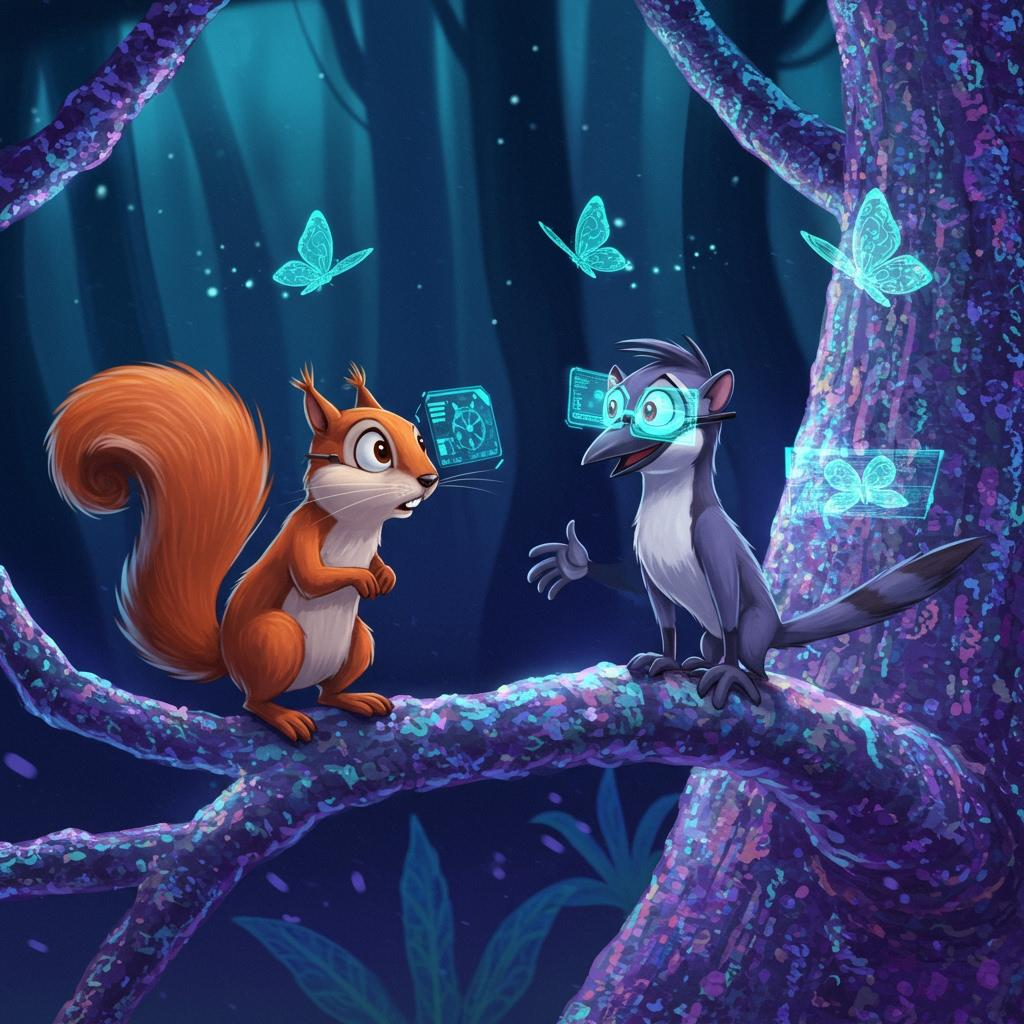

In [ ]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  for generated_image in image_generated.generated_images:
    image = generated_image.image.show()

  # Be careful, long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here's what it should look like when you run it:

-----------

**Chapter 1 Illustration Prompt**  
Create a futuristic, science fiction image of Chatterer the Red Squirrel running for his life through a forest filled with neon-lit, bioluminescent plants and towering, chrome trees. The forest floor is a mosaic of holographic projections, creating a surreal, dreamlike atmosphere. Utopia, saturated art style. Shadow the Weasel is in hot pursuit, his cybernetic eyes glowing with predatory hunger, leaving a faint neon trail that distorts the air. Chatterer, small and terrified, augmented with a speed booster that leaves a shimmering afterimage, leaps desperately from tree to tree, his bright red, neon-infused fur a blur against the vibrant background. Imagine the scene filled with a pounding synthwave soundtrack, with a sense of urgency and danger permeating the scene, emphasizing Chatterer's vulnerability and Shadow's relentless pursuit.

![Generated image of the 1st chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter1_audio.png)

**Chapter 2 Illustration Prompt**  
Create a futuristic, science fiction image of Chatterer the Red Squirrel scrambling up a towering, genetically-modified chestnut tree that spirals upwards, supported by visible energy conduits, toward Red Tail the Hawk, who is dozing on a high-tech perch made of polished chrome, head tucked between his cybernetically enhanced shoulders. Utopia, saturated art style. Chatterer's augmented eyes are wide with a daring plan, calculating angles and trajectories, as Shadow the Weasel follows close behind, his movements leaving subtle distortions in the air and glitching holographic leaves. The scene should be a mix of tension and vibrant color, capturing the risk and ingenuity of Chatterer's actions, with neon accents illuminating the genetically-altered foliage and emphasizing the futuristic setting. Glimpses of advanced technology can be seen embedded within the tree's structure.

![Generated image of the 2nd chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter2_audio.png)

Chapter 3 Illustration Prompt
Create a futuristic, science fiction image of Chatterer the Red Squirrel urgently telling Sammy Jay about Shadow the Weasel, their figures illuminated by glowing data streams. Utopia, saturated art style. Sammy Jay listens with wide, attentive eyes, augmented with holographic displays that project potential threats, perched on a branch of a tree constructed from shimmering, nanotech materials that seem to shift and change color. The lighting is vibrant, emphasizing the important news being shared, with a technologically advanced forest in the background hinting at the scale of Chatterer's warning. Holographic butterflies, acting as data couriers, flutter around Sammy as he processes the news, their wings leaving trails of light.

![Generated image of the 3rd chapter](https://storage.googleapis.com/generativeai-downloads/images/chapter3_audio.png)

# Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Related examples

If you're curious about cool things you can build with Imagen, check those great examples:
* [Zoom on earth](../examples/Zoom_on_earth.ipynb): Another take on mixing Gemini and Imagen, this time using [function calling](./Function_calling.ipynb) to communicate.
* [Generative designs](../examples/Generative_designs.ipynb): This time Gemini will ingest a bunch of images to serve as models to generate model designs.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.

You should also have a look at the [Live API](../quickstarts/Get_started_LiveAPI.ipynb) to create live intereactions with the models.
